In [1]:
import pandas as pd
import numpy as np
import duckdb
import dotenv
import os

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, SplineTransformer, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge, GammaRegressor, TweedieRegressor, LinearRegression
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_percentage_error

In [2]:
dotenv.load_dotenv()

True

In [3]:
md_token = os.environ['MOTHERDUCK_TOKEN']


con = duckdb.connect(f'md:?motherduck_token={md_token}')
df = con.query('select * from bike.staging.fact_trips_feature_store where station_trips is not null and station_trips > 0;').df()
df['time'] = (df.toronto_local_time - df.toronto_local_time.min()).dt.days




df_test = df.tail(24*30)
df_train = df[~df.toronto_local_time.isin(df_test.toronto_local_time)]

y_train = df_train.station_trips.values
y_test = df_test.station_trips.values


In [4]:
df.tail()

,toronto_local_time,year,month,month_pct,day_of_year,day_of_week,hour,station_trips,temperature_2m,relative_humidity_2m,apparent_temperature,cloud_cover,wind_speed_10m,precipitation,snowfall,holiday,time
32354,2024-09-10 19:00:00,2024,September,0.333333,254,Tuesday,19,2266,20.5,49.0,19.5,19.0,12.4,0.0,0.0,000NoHoliday,1348
32355,2024-09-10 20:00:00,2024,September,0.333333,254,Tuesday,20,1676,20.5,44.0,18.8,23.0,11.1,0.0,0.0,000NoHoliday,1348
32356,2024-09-10 21:00:00,2024,September,0.333333,254,Tuesday,21,1281,20.5,44.0,18.6,29.0,9.6,0.0,0.0,000NoHoliday,1348
32357,2024-09-10 22:00:00,2024,September,0.333333,254,Tuesday,22,1036,20.1,46.0,18.1,30.0,10.0,0.0,0.0,000NoHoliday,1348
32358,2024-09-10 23:00:00,2024,September,0.333333,254,Tuesday,23,1310,18.7,50.0,17.2,29.0,6.7,0.0,0.0,000NoHoliday,1348


In [5]:
from sklearn.preprocessing import OneHotEncoder

# Example: drop specific category for each feature
encoder = OneHotEncoder(drop = 'first' , sparse_output=False)

# Fit and transform your data
encoder.fit_transform(df[['holiday']].values)


print(encoder.get_feature_names_out())


['x0_Boxing Day' 'x0_Boxing Day (observed)'
 'x0_Boxing Day; Christmas Day (observed)' 'x0_Canada Day'
 'x0_Christmas Day' 'x0_Christmas Day (observed)' 'x0_Family Day'
 'x0_Good Friday' 'x0_Labour Day' "x0_New Year's Day"
 "x0_New Year's Day (observed)" 'x0_Thanksgiving Day' 'x0_Victoria Day']


In [6]:
categorical_features = ['month','day_of_week']
holiday_features = ['holiday']
numerical_features = ['year', 'temperature_2m', 'relative_humidity_2m','apparent_temperature','cloud_cover','wind_speed_10m', 'precipitation','snowfall']
nonlinear_features = ['hour']
time_features = ['time', 'month_pct']


categorical_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

holiday_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(drop = 'first' , sparse_output=False))
])

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

nonlinear_pipeline = Pipeline([
    ('splines', SplineTransformer(include_bias=True, extrapolation='periodic', knots=np.arange(0, 24, 1).reshape(-1, 1)))
])

time_pipeline = Pipeline([
    ('time', SplineTransformer(extrapolation='linear'))
])


ct = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('nonlinear', nonlinear_pipeline, nonlinear_features), 
    ('time', time_pipeline, time_features),
    ('holiday',holiday_pipeline, holiday_features)
    
], remainder='drop')


model = Pipeline([
    ('column_transformer', ct), 
    ('knnImputer', KNNImputer(n_neighbors=10) ),
    ('scaler', StandardScaler()),
    ('ridge', GammaRegressor(max_iter=10_000))

])

params = {
    'ridge__alpha': 2**np.linspace(-5, 5, 10),
    'column_transformer__time__time__knots': ['quantile','uniform'], 
    'column_transformer__time__time__n_knots': [5, 10, 20, 50], 
}

rmse = make_scorer(root_mean_squared_error, greater_is_better=False)
mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scorers = {'rmse':rmse, 'mape': mape}

gscv = GridSearchCV(
    estimator=model,
    param_grid=params, 
    cv=TimeSeriesSplit(n_splits=12, test_size=24*30), 
    scoring=scorers,
    n_jobs = -1, 
    verbose=4, 
    refit='mape'
)

fit = gscv.fit(df_train, y_train)

Fitting 12 folds for each of 80 candidates, totalling 960 fits
[CV 1/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125; mape: (test=-0.283) rmse: (test=-337.195) total time=   0.5s
[CV 3/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125; mape: (test=-0.370) rmse: (test=-216.755) total time=   0.6s
[CV 2/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125; mape: (test=-0.303) rmse: (test=-302.475) total time=   0.6s
[CV 5/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125; mape: (test=-0.761) rmse: (test=-168.191) total time=   0.7s
[CV 4/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125; mape: (test=-0.350) rmse: (test=-164.246) total time=   0.

/Users/demetripananos/Repos/bike/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 6/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.1458161299470146; mape: (test=-0.356) rmse: (test=-166.007) total time=   0.5s
[CV 7/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.1458161299470146; mape: (test=-0.442) rmse: (test=-165.382) total time=   0.5s
[CV 8/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.1458161299470146; mape: (test=-0.595) rmse: (test=-223.308) total time=   0.5s
[CV 10/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.1458161299470146; mape: (test=-0.355) rmse: (test=-359.994) total time=   0.4s
[CV 9/12] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.1458161299470146; mape: (test=-0.359) rmse: (test=-291.195) total time=   0.6s
[CV 

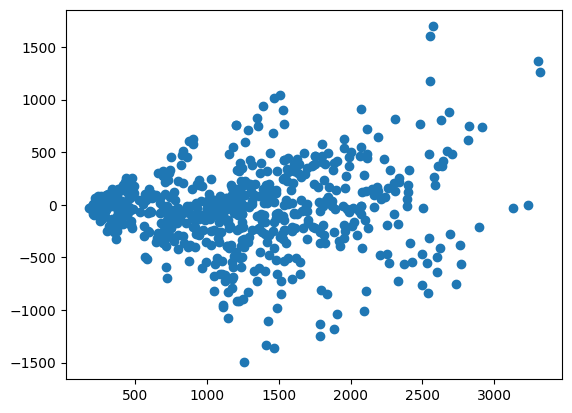

In [7]:
ypred = fit.predict(df_test)

plt.scatter(ypred, ypred-y_test)

In [8]:
fit.best_score_

np.float64(-0.385914924644033)

In [9]:
mean_absolute_percentage_error(y_test, ypred)

np.float64(0.24554686356412933)

In [10]:
df_test['pred'] = ypred

/var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/ipykernel_48685/3400341002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = ypred


/var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/ipykernel_48685/2617373409.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['error'] = (df_test.pred - df_test.station_trips)/df_test.station_trips


<Axes: xlabel='toronto_local_time'>

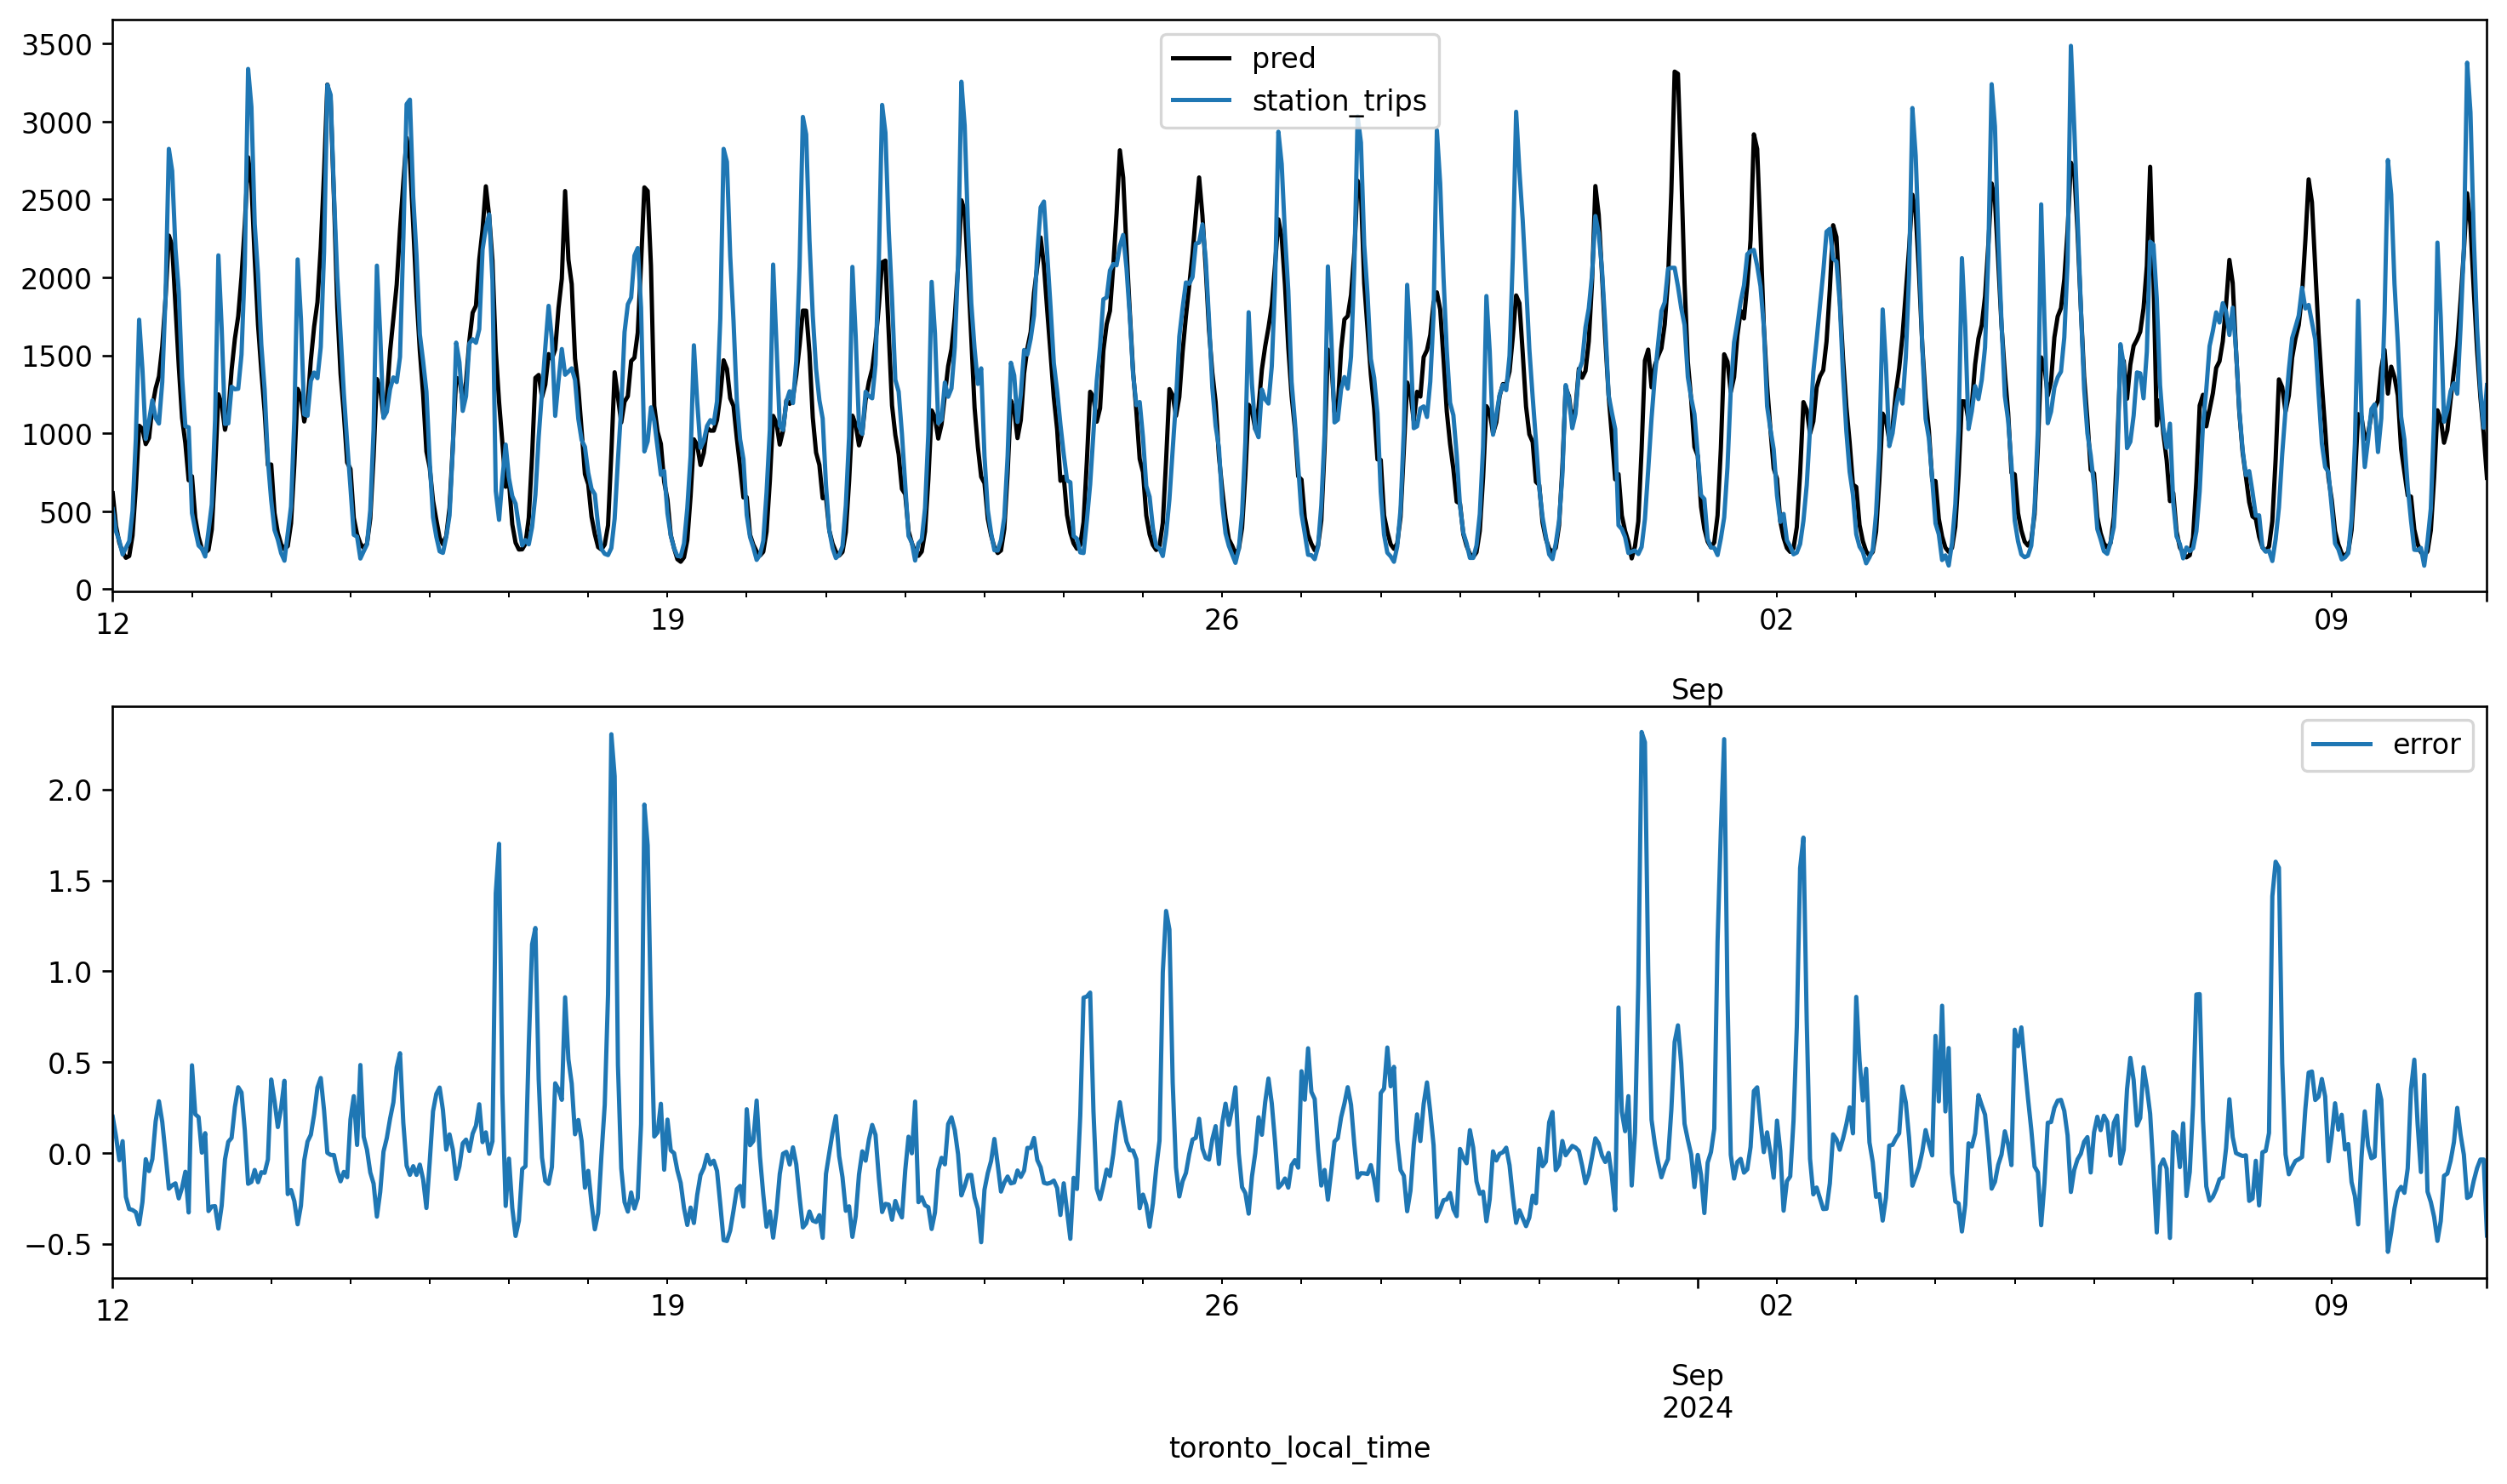

In [11]:
fig, ax = plt.subplots(dpi = 240, figsize = (15, 8), nrows=2)
ax1, ax2 = ax
df_test.plot(x='toronto_local_time', y='pred', ax = ax1, color='k')
df_test.plot(x='toronto_local_time', y='station_trips', ax = ax1)

df_test['error'] = (df_test.pred - df_test.station_trips)/df_test.station_trips


df_test.plot(x='toronto_local_time', y='error', ax=ax2)

/var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/ipykernel_48685/3932380751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['resid'] = df_test.pred - df_test.station_trips
/var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/ipykernel_48685/3932380751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['scaled_resid'] = (df_test.pred - df_test.station_trips) / df.station_trips


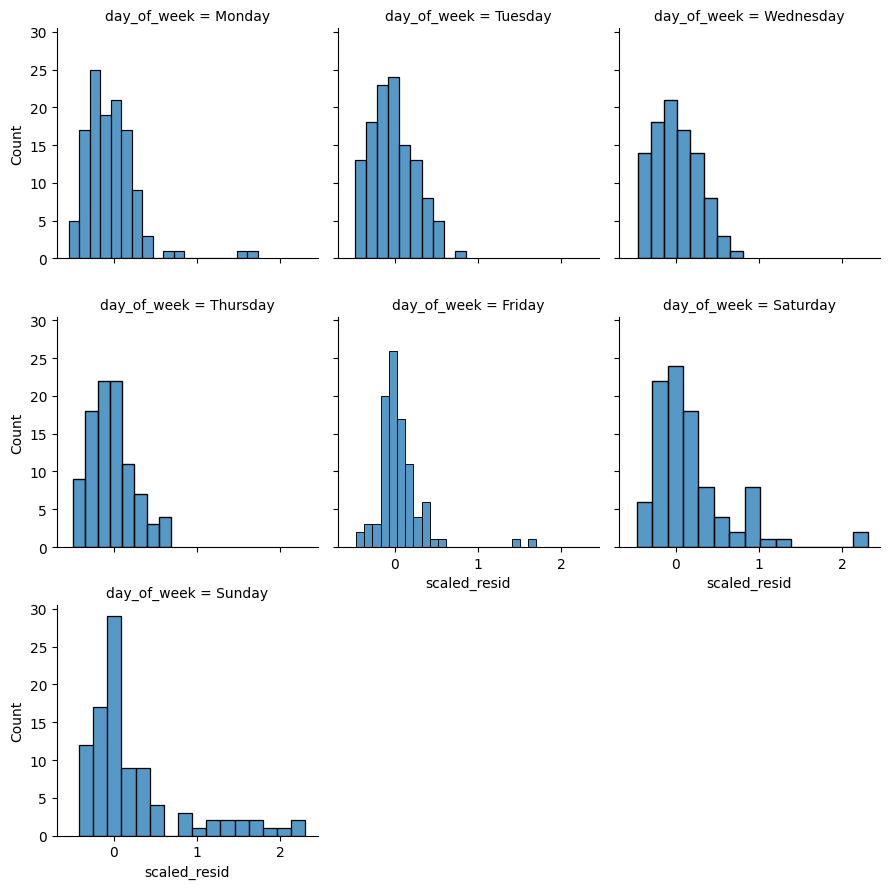

In [12]:
import seaborn as sns

df_test['resid'] = df_test.pred - df_test.station_trips
df_test['scaled_resid'] = (df_test.pred - df_test.station_trips) / df.station_trips
fg = sns.FacetGrid(data = df_test, col='day_of_week', col_wrap=3)

fg.map(sns.histplot, 'scaled_resid')